# Bulk deconvolution

In this chapter, we show the basic concepts of cell type deconvolution, including the structure of inputs, data preprocessing, how to run the deconvolution process and the analysis of the outputs. We demonstrate the full pipeline using the **MuSiC** deconvolution method.

## Background

Studying differences in cell type compositions within a bulk tissue is very important. First, interactions between cell types play a major role in disease progression and recovery. Second, molecular patterns (such as gene expression and protein abundance) are often directly associated with the cell types compositions within the tissue. Understanding these compositions is crutial for studying the underlying molecular mechanisms of a biological condition, such as disease. Third, uncovering disease-specific cell type patterns allow for better therapeutic targeting, providing an important clinical utility.

Cell type deconvolution is a computational framework designed for inferring the compositions of cell populations within a bulk heterogeneous tissue {cite}`Kuhn2012,Schwartz2010,Du2019,Zaitsev2019`. As measuring these compositions experimentally is fairly time consuming and expensive, deconvolution methods allow large scale analysis of cell populations, relying solely on molecular data. Deconvolution methods usually follow linear regression defined as: 

$y = bX$ 

where, $y$ refers to a mixture of heterogeneous gene expression profile using common molecular pipelines (e.g. microarray or RNA-seq), $X$ is a signature matrix containing homogeneous cell type-specific profiles, and $b$ is the vector of cellular proportions in the mixture data inferred by the deconvolution method {cite}`Baron2016`. To select an optimal deconvolution method suitable for the targeted biological conditions, the impact of several technical and biological factors should be considered including: the deconvolution method, reference data with missing or rare cell types, data normalization and the selection of features (markers).

The signature matrix $X$, used to infer cellular compositions, reflects our best knowledge of cellular heterogeneity within the tissue and highly influences the success of the deconvolution process {cite}`Aliee2021,Wang2019`. Originally, signature matrices were generated by profiling sorting cells from a heterogeneous tissue (using FACS or CyTOF), suffering from internal biases due to the pre-selection of cell type panels and the absence of appropriate antibodies {cite}`Monaco2019,Aran2019`. Today, these matrices are mainly generated as unbiased profiles using single cell technologies, allowing the generation of signature matrices across different organisms, tissues and biological conditions {cite}`Aliee2021,Wang2019,Newman2019`.

## Related Work

During the last decade, many benchmarking papers have been published, highlighting the advantages and disadvantages of different cell deconvolution methods {cite}`ShenOrr2013,Cobos2020,Jin2021,Nadel2021`. Here is a list of some of the prominant methods including CibersortX, MuSiC, dtangle, DWLS, xCell and Scaden. It should be mentioned that there are several other deconvolution methods proposed recently that have not been studied in those benchmarking papers (described in the 'new directions' section).

### Linear regression-based methods
The most common type of cell type deconvolution methods are linear regression-based. These methods try to directly solve the $y = bX$ equation using different regularizations and relying on a relatively high number of features.

**CibersortX** {cite}`Newman2019` is one of the widely used deconvolution method. 
It uses transcriptome profiling of single cells or sorted cell subpopulations to define a signature matrix consisting of barcode genes that can discriminate each cell subset of interest in a given tissue type. The important genes are inferred using condition number and the deconvolution is performed using support vector regression that accounts for outliers.

CibersortX is a web-based tool. [Link to the website](https://cibersortx.stanford.edu)

**MuSiC** {cite}`WangXuran2019` MuSiC is a widely used deconvolution method.
It is based on multi-subject single cell data where the cells for each subject have been classified into a set of fixed cell types that are shared across subjects. Using scRNA-seq data as a reference for cell type deconvolution, MuSiC considers cross-subject and cross-cell consistency to guard against biases either in subject selection or in cells capture in scRNA-seq. It up-weighs genes with low cross-subject variance which is critical for transferring cell type-specific gene expression information from one dataset to another, and uses NNLS for deconvolution.

MuSiC is an R-based tool. [Link to the github](https://github.com/xuranw/MuSiC)

**dtangle** {cite}`Hunt2018` dtangle’s approach is built on a biologically appropriate linear mixing model of linear-scale expressions but robustly fitting the model using log-transformed data and thus sets it apart from other deconvolution methods.
However,it assumes to know both the reference profile and the marker genes. 

dtangle is an R-based tool. [Link to the github](https://github.com/gjhunt/dtangle)

**DWLS** {cite}`Tsoucas2019` Dampened weighted least squares (DWLS) is a deconvolution method that corrects common biases towards cell types that are characterized by highly expressed genes and/or are highly prevalent, to provide accurate detection across diverse cell types. It uses a weighted least squares approach to properly adjust the contribution of each gene.

DWLS is written in R. [Link to the github](https://github.com/dtsoucas/DWLS)


### Enrichment-based methods
Enrichment-based methods calculate an enrichment score for each cell type separately, based on a gene set that represents this cell type. The enrichment scores for all cell types are then combined together and transformed to compositions by a method-specific transformation function. As these methods only consider a single cell type at a time, tend to provide meaningful insights in simple cases, but are less accurate when reference data includes many cell types.

**xCell** {cite}`Aran2017` xCell is an enrichment-based method which learns cell type compositions based on pre-selected sets of markers per cell type. The power of this method is its pretrained gene signatures learned from thousands of pure cell types from various sources.

xCell is written in R. [Link to the github](https://github.com/dviraran/xCell)

### Non-linear deep learning methods
Non-linear deep learning methods have also emerged with the promise of improving deconvolution accuracy, while still attempting to maintain high biological interpretability. It is still early to say whether these methods can be better than other types of methods.

**Scaden** {cite}`Menden2020` Scaden trains a model using simulated pseudo bulk samples generated from a heterogeneous single cell data with known cell type compositions. It then trys to predict the compositions of bulk samples based on this deep learning model.

Scaden is written in Python. [Link to the github](https://github.com/KevinMenden/scaden)

In the following, we demonstrate a deconvolution example using *MuSiC*. MuSiC has shown good performance in the benchmarking papers and is easy to run.

It is important to note that MuSiC requires multiple single-cell samples including the same cell types. In practice, our reference profile might not include more than a single sample or some cell types might be missing across the samples. In these cases, MuSiC fails and another deconvolution method should be selected. 

## Loading libraries

In [1]:
import scanpy as sc
import anndata
import numpy as np
import pandas as pd
import sys
import importlib
import scipy as sci

## Loading Data

We start by reading both single-cell and bulk data. In this chapter, we will demonstrate the deconvolution framework using whole blood single-cell RNA-seq data of patients with COVID-19 {cite}`Schulte-Schrepping2020`. We do not scale the data as it has been shown that deconvolution methods using scRNA-seq data as reference perform best when applied to data in linear scale with improved accuracy after library size normalization {cite}`Jin2021,Cobos2020`. 

In [2]:
#read single-cell data
data_file = '/storage/groups/ml01/workspace/amit.frishberg/OriginalData/' 
adata = sc.read(data_file+"seurat_COVID19_freshWB_PBMC_cohort2_incl_raw.h5ad")

#adata.X = adata.X.todense()
adata.X = adata.layers['counts']
adata = adata[adata.obs['cells']=='Whole_blood'].copy()
adata

AnnData object with n_obs × n_vars = 89883 × 33417
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'percent.mito', 'percent.hb', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'demultID', 'donor', 'onset_of_symptoms', 'days_after_onset', 'sampleID', 'date_of_sampling', 'experiment', 'cartridge', 'platform', 'purification', 'cells', 'age', 'sex', 'group_per_sample', 'who_per_sample', 'disease_stage', 'diagnosis', 'oxygen', 'outcome', 'comorbidities', 'COVID.19.related_medication_and_anti.microbials', 'primary_complaint', 'RNA_snn_res.0.8', 'cluster_labels_res.0.8', 'new.order', 'hpca.labels', 'blueprint.labels', 'monaco.labels', 'immune.labels', 'dmap.labels', 'hemato.labels'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [3]:
adata.obs['cluster_labels_res.0.8'].value_counts()

Neutrophils_1             22714
Neutrophils_2             18675
Neutrophils_3              9986
CD4_T_cells_1              6278
CD14_Monocytes_1           5362
Neutrophils_4              4710
CD8_T_cells                3255
Megakaryocytes             3180
NK_cells                   2916
B_cells_1                  2561
CD4_T_cells_2              1917
Mixed_cells                1727
Immature Neutrophils_1     1317
CD16_Monocytes              983
Immature Neutrophils_2      981
CD14_Monocytes_3            632
Eosinophils                 579
CD14_Monocytes_2            556
CD4_T_cells_3               409
Plasmablast                 390
Prol. cells                 247
mDC                         235
B_cells_2                   138
pDC                          86
CD34+ GATA2+ cells           49
Name: cluster_labels_res.0.8, dtype: int64

The bulk data contains 49 bulk whole blood RNA-seq samples collected from 39 COVID-19 patients and 10 healthy controls {cite}`Aschenbrenner2020`. 

In [4]:
#read bulk data
bulk = pd.read_csv(data_file + "BulkSmall.txt", sep = "\t", index_col = 0)
metadata = pd.read_csv(data_file +"annoSmall.txt", sep = "\t", index_col = 0)
metadata.index = metadata.index.astype('str')
metadata = metadata.loc[bulk.transpose().index]

## Data preprocessing

After reading the data, we need to remove *undefined* and very *rare* cells from our single-cell reference data.
It has been shown that deconvolution methods commonly fail to predict the proportion of rare cells.
Here, we remove mixed and proliferating cells which are not limited to a single cell type and limited cell types to be above 50 cells. This cutoff is user-defined and should be selected based on the data.

**Note** Quality control by means of removing low quality cells and genes has already been perform on the single-cell data. So, we skip that.

In [5]:
# removing undefined cell types
adata = adata[~adata.obs['cluster_labels_res.0.8'].isin(['None','Mixed_cells','Prol. cells'])].copy()
cellTypeCounts = adata.obs['cluster_labels_res.0.8'].value_counts()

#removing very rare cells
cellTypeNumCutOff = 50 # This is a user-specific parameter based on the data
cellTypesToUse = cellTypeCounts[cellTypeCounts>cellTypeNumCutOff].index
adata = adata[adata.obs['cluster_labels_res.0.8'].isin(cellTypesToUse)].copy()
adata.obs['cluster_labels_res.0.8'].value_counts()

Neutrophils_1             22714
Neutrophils_2             18675
Neutrophils_3              9986
CD4_T_cells_1              6278
CD14_Monocytes_1           5362
Neutrophils_4              4710
CD8_T_cells                3255
Megakaryocytes             3180
NK_cells                   2916
B_cells_1                  2561
CD4_T_cells_2              1917
Immature Neutrophils_1     1317
CD16_Monocytes              983
Immature Neutrophils_2      981
CD14_Monocytes_3            632
Eosinophils                 579
CD14_Monocytes_2            556
CD4_T_cells_3               409
Plasmablast                 390
mDC                         235
B_cells_2                   138
pDC                          86
Name: cluster_labels_res.0.8, dtype: int64

**Note**: we need to filter for the shared genes across bulk and single-cell data before selecting highly variable genes

In [6]:
#synchronize single-cell and bulk genes
bulk_sc_genes = np.intersect1d(bulk.index,adata.var_names)
bulk = bulk.loc[bulk_sc_genes,:].copy()
adata = adata[:,bulk_sc_genes].copy()

## Visualization of single-cell data

For visualization of single-cell data, we first normalize the counts, select the highly-variable genes and log transform the data.

In [7]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4,copy=False)
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=5000)
adata_log = sc.pp.log1p(adata, copy=True) #logged counts are only used for visualisation 

We then reduce the dimensionality using PCA and visualize the data using UMAP:

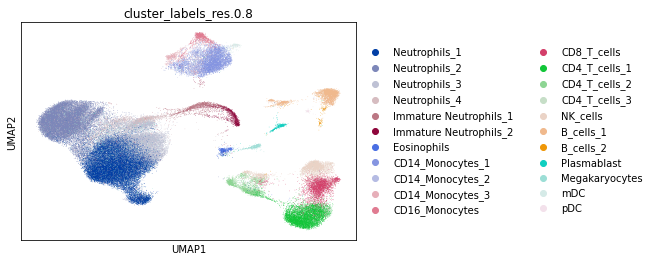

In [10]:
sc.tl.pca(adata_log)
adata_log.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat
sc.pp.neighbors(adata_log, n_neighbors=30)
sc.tl.umap(adata_log)
sc.pl.umap(adata_log, color='cluster_labels_res.0.8')

## Deconvolving using MuSiC (an example pipeline)

### Loading R

In order to run R-based MuSiC in Python, we utilized the rpy2 Python package that allows runing R code through Python kernels. 

In [8]:
# R interface
from rpy2.robjects import pandas2ri
from rpy2.robjects import r
import rpy2.rinterface_lib.callbacks
import anndata2ri

pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

C:\Users\Shennor\.conda\envs\eharpy\lib\site-packages\rpy2\robjects\packages.py:365: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


To use the R scripts, we need to convert the data from Python to R. In some cases, it is requires to do sub-sampling of the data in order to avoid memory limitations.

In [23]:
import random
import itertools
downSamplingSize = 80
downSamplingIndexes = [random.sample(np.where(currCell == adata.obs['cluster_labels_res.0.8'])[0].tolist(),downSamplingSize) for currCell in np.unique(adata.obs['cluster_labels_res.0.8'])]
downSamplingIndexes = list(itertools.chain(*downSamplingIndexes))

adata_r = adata[downSamplingIndexes].copy()
adata_r

AnnData object with n_obs × n_vars = 1760 × 26807
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'percent.mito', 'percent.hb', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'demultID', 'donor', 'onset_of_symptoms', 'days_after_onset', 'sampleID', 'date_of_sampling', 'experiment', 'cartridge', 'platform', 'purification', 'cells', 'age', 'sex', 'group_per_sample', 'who_per_sample', 'disease_stage', 'diagnosis', 'oxygen', 'outcome', 'comorbidities', 'COVID.19.related_medication_and_anti.microbials', 'primary_complaint', 'RNA_snn_res.0.8', 'cluster_labels_res.0.8', 'new.order', 'hpca.labels', 'blueprint.labels', 'monaco.labels', 'immune.labels', 'dmap.labels', 'hemato.labels', 'n_counts'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    obsm: 'X_pca', 'X_umap'


If sub-sampling is not required (data is relatively small), one can simply convert the entire adata to an R object

In [21]:
adata_r = adata.copy()
adata_r

AnnData object with n_obs × n_vars = 87860 × 26807
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'percent.mito', 'percent.hb', 'HTO_maxID', 'HTO_secondID', 'HTO_margin', 'HTO_classification', 'HTO_classification.global', 'hash.ID', 'demultID', 'donor', 'onset_of_symptoms', 'days_after_onset', 'sampleID', 'date_of_sampling', 'experiment', 'cartridge', 'platform', 'purification', 'cells', 'age', 'sex', 'group_per_sample', 'who_per_sample', 'disease_stage', 'diagnosis', 'oxygen', 'outcome', 'comorbidities', 'COVID.19.related_medication_and_anti.microbials', 'primary_complaint', 'RNA_snn_res.0.8', 'cluster_labels_res.0.8', 'new.order', 'hpca.labels', 'blueprint.labels', 'monaco.labels', 'immune.labels', 'dmap.labels', 'hemato.labels', 'n_counts'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    obsm: 'X_pca', 'X_umap'

### Running MuSiC

In the next steps, we load the MuSiC R package and show how to use it with our example single cell and bulk datasets.

In [24]:
%%R
library(MuSiC)
library(Biobase)

We will first gather all the remaining inputs needed for running MuSiC:
    <br>1. adata_r - contains the single cell matrix which will used as a reference.
    <br>2. cellSubsets_r - cell type identities.
    <br>3. bulk - the bulk samples which the deconvolution process will be conducted on.
    <br>4. scGenes - gene markers used in the MuSiC analysis.

In [25]:
cellSubsets_r = adata_r.obs['cluster_labels_res.0.8'].astype(str).copy()
scGenes = adata_r.var_names

MuSiC runs the deconvolution framework one sample at a time. Here, 9*** are sample names.

In [33]:
%%R -i adata_r,cellSubsets_r,bulk,scGenes -o musicRes
df = data.frame(cellNames = cellSubsets_r, Sample = factor(rep(1, dim(adata_r@colData)[1])))
row.names(df) = row.names(adata_r@colData)
df = new("AnnotatedDataFrame", data = df) # Cell type identities are stored as an AnnotatedDataFrame

# Creating an ExpressionSet from the single cell matrix
scDataMatrix = Matrix::as.matrix(adata_r@assays@data@listData[[1]])
row.names(scDataMatrix) = scGenes
scDataMatrix = scDataMatrix[rowSums(scDataMatrix)>0,] # Removing genes with no reads
SCDataES <- Biobase::ExpressionSet(assayData=scDataMatrix,phenoData = df, protocolData = df)

bulkDataES <- Biobase::ExpressionSet(assayData=as.matrix(bulk)) # Creating an ExpressionSet from the bulk matrix
musicRes = MuSiC::music_prop(bulk.eset = bulkDataES, sc.eset = SCDataES, clusters = 'cellNames') # Running MuSiC

R[write to console]: Creating Relative Abundance Matrix...

R[write to console]: Creating Variance Matrix...

R[write to console]: Creating Library Size Matrix...

R[write to console]: Used 20157 common genes...

R[write to console]: Used 22 cell types in deconvolution...

R[write to console]: 9088 has common genes 18147 ...

R[write to console]: 9089 has common genes 17667 ...

R[write to console]: 9091 has common genes 18454 ...

R[write to console]: 9092 has common genes 16108 ...

R[write to console]: 9093 has common genes 18443 ...

R[write to console]: 9094 has common genes 18596 ...

R[write to console]: 9095 has common genes 18441 ...

R[write to console]: 9096 has common genes 17156 ...

R[write to console]: 9097 has common genes 17817 ...

R[write to console]: 9098 has common genes 17880 ...

R[write to console]: 9099 has common genes 18126 ...

R[write to console]: 9100 has common genes 18672 ...

R[write to console]: 9101 has common genes 16400 ...

R[write to console]: 910

In [27]:
# Create the final output matrix
musicFrac = pd.DataFrame(musicRes[0])
musicFrac.index = bulk.columns
musicFrac.columns = np.unique(cellSubsets_r)

### Outputs and Validations

The main output of all cell type deconvolution methods is a NxM matrix, where:
    <br>N (rows) - number of samples
    <br>M (columns) - the number of cell types
<br>The values of each cell in the matrix represents the cell type composition of a specific cell type within a specific sample. In most cases, cell type compositions in a sample with be shown as fractions therefore, non-negative values, summing to one.

In [28]:
musicFrac

,B_cells_1,B_cells_2,CD14_Monocytes_1,CD14_Monocytes_2,CD14_Monocytes_3,CD16_Monocytes,CD4_T_cells_1,CD4_T_cells_2,CD4_T_cells_3,CD8_T_cells,...,Immature Neutrophils_2,Megakaryocytes,NK_cells,Neutrophils_1,Neutrophils_2,Neutrophils_3,Neutrophils_4,Plasmablast,mDC,pDC
9088,0.052073,0.025893,0.050551,0.000000,0.033511,0.000000,0.126068,0.0,0.014385,0.000000,...,0.022197,0.146371,0.043853,0.018623,0.000000,0.000000,0.140044,0.059844,0.0,0.000000
9089,0.000000,0.000000,0.044778,0.042559,0.000000,0.000000,0.002236,0.0,0.000000,0.000000,...,0.012217,0.122904,0.000904,0.181556,0.000000,0.038412,0.215370,0.001146,0.0,0.000000
9091,0.000247,0.000000,0.039231,0.000000,0.017230,0.000401,0.000109,0.0,0.000033,0.000000,...,0.000000,0.210100,0.009966,0.179916,0.000000,0.039518,0.247490,0.011103,0.0,0.000180
9092,0.000000,0.000000,0.000000,0.000000,0.002512,0.000000,0.002762,0.0,0.000000,0.000000,...,0.000493,0.249933,0.007348,0.098269,0.000000,0.000000,0.251413,0.016071,0.0,0.000000
9093,0.011014,0.000000,0.000000,0.000000,0.159980,0.000000,0.037521,0.0,0.000290,0.000000,...,0.000000,0.087162,0.025315,0.001755,0.211280,0.000832,0.233358,0.004563,0.0,0.000139
9094,0.155228,0.013870,0.001671,0.000000,0.035358,0.000000,0.076355,0.0,0.000775,0.000000,...,0.009433,0.038603,0.033760,0.000000,0.133637,0.000000,0.137554,0.000000,0.0,0.000000
9095,0.012138,0.000000,0.000000,0.106092,0.036671,0.000476,0.010450,0.0,0.000082,0.000000,...,0.000149,0.124863,0.011601,0.091784,0.024656,0.000596,0.320481,0.007001,0.0,0.000219
9096,0.038552,0.000000,0.047748,0.058157,0.000000,0.000000,0.046780,0.0,0.002164,0.000000,...,0.000000,0.116041,0.080441,0.104472,0.150451,0.000000,0.046812,0.020210,0.0,0.000000
9097,0.031702,0.000000,0.030897,0.105587,0.000000,0.000000,0.061240,0.0,0.000000,0.000000,...,0.000000,0.095577,0.077498,0.088980,0.041896,0.000000,0.146600,0.044135,0.0,0.001123
9098,0.036664,0.000000,0.091498,0.025261,0.000000,0.000000,0.097084,0.0,0.025174,0.000000,...,0.000389,0.102177,0.084075,0.124119,0.007186,0.000000,0.027252,0.090006,0.0,0.000148


In case we know the true fractions of the cell types across sample, we can validate our deconvolved compositions. Here, Neutrophil counts were measures and indeed we found high correlations between the measured values and our decovolution-based results.

In [29]:
neutCounts = metadata['Total.neutrophil.count...mm3.'].astype(float)
subsetCorMuSiC = pd.Series(np.corrcoef(musicFrac.to_numpy()[~np.isnan(neutCounts.to_numpy()),:].transpose(),
                                       neutCounts[~np.isnan(neutCounts.to_numpy())].astype(float))[musicFrac.shape[1],0:musicFrac.shape[1]])
subsetCorMuSiC.index = musicFrac.columns
subsetCorMuSiC.sort_values()

C:\Users\Shennor\AppData\Roaming\Python\Python38\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Shennor\AppData\Roaming\Python\Python38\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


NK_cells                 -0.521110
CD4_T_cells_1            -0.494776
CD4_T_cells_3            -0.347456
B_cells_1                -0.342369
Eosinophils              -0.301084
pDC                      -0.274450
CD14_Monocytes_1         -0.191633
CD14_Monocytes_2         -0.182610
CD8_T_cells              -0.182339
CD16_Monocytes           -0.166790
Neutrophils_2            -0.099848
Immature Neutrophils_1    0.020930
Plasmablast               0.052610
CD14_Monocytes_3          0.068038
B_cells_2                 0.116006
Neutrophils_1             0.273809
Neutrophils_3             0.328049
Immature Neutrophils_2    0.343492
Megakaryocytes            0.345558
Neutrophils_4             0.574176
CD4_T_cells_2                  NaN
mDC                            NaN
dtype: float64

We can also look for significant changes in cell compositions between disease patients and healthy controls. In this case, for each cell type, we calcualte the p-value of this change based on student's t-test.

In [30]:
import scipy as sci
healthyVsCOVID = pd.Series([sci.stats.ttest_ind(musicFrac[cell].to_numpy()[metadata['status'].to_numpy()=="covid"], 
                     musicFrac[cell].to_numpy()[metadata['status'].to_numpy()=="healthy"])[1] for cell in musicFrac.columns])
healthyVsCOVID.index = musicFrac.columns
healthyVsCOVID.sort_values()

CD4_T_cells_1             7.550577e-10
CD4_T_cells_3             3.822744e-07
pDC                       3.989288e-07
Eosinophils               1.214738e-06
Megakaryocytes            8.818421e-06
B_cells_1                 1.973721e-05
Neutrophils_4             3.369797e-04
Plasmablast               5.981765e-03
B_cells_2                 1.308948e-02
Neutrophils_2             2.261395e-02
CD14_Monocytes_1          3.095695e-02
NK_cells                  3.685150e-02
Immature Neutrophils_2    1.054000e-01
Immature Neutrophils_1    1.303613e-01
CD14_Monocytes_2          1.442149e-01
CD14_Monocytes_3          1.679401e-01
Neutrophils_3             4.642664e-01
CD8_T_cells               6.177244e-01
CD16_Monocytes            7.519942e-01
Neutrophils_1             9.786608e-01
CD4_T_cells_2                      NaN
mDC                                NaN
dtype: float64

Here is a boxplot presenting the differences between the two conditions

<AxesSubplot:title={'center':'cellFraction'}, xlabel='[status]'>

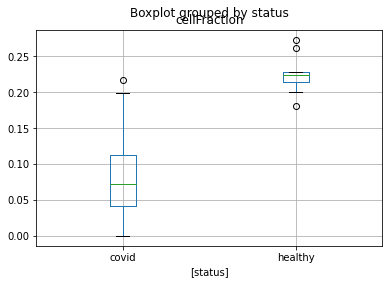

In [31]:
selectedCell = healthyVsCOVID.index[np.nanargmin(healthyVsCOVID.to_numpy())]
dfForPlot = pd.DataFrame(metadata['status'])
dfForPlot['cellFraction'] = musicFrac[[selectedCell]]
dfForPlot.boxplot(by='status')

## Limitations and traps

While single cell data is less prone to contain missing cell types, compared to pre-selected sorted cells, dealing with missing cell types is still considered a major challenge in the field of cell type deconvolution to this day {cite}`Cobos2020,Jin2021`. In addition, the number of cell types within the signature matrix has a major influence on deconvolution accuracy, as more cell types usually results in a less accurate deconvolution process {cite}`Newman2019`. 

While several deconvolution methods can correctly infer the proportion of major cellular components, their performance for rare or correlated components varies. To deal with the collinearity between the predictors (mean expressions of cell types, some methods perform feature selection prior deconvolution by selecting a subset of genes (called signature gene list) that minimizes the correlation between cell types. They illustrate that applying feature selection improves the deconvolution results significantly {cite}`Aliee2021`.

# New directions

Other than the methods we described before, there are additional tools which can be utilize to either improve deconvolution or decovolve higher resolution states within cell types:

**AutoGeneS** {cite}`Aliee2021` proposes a multi-objective feature selection method that can be integrated into a deconvolution platform. AutoGeneS requires no prior knowledge about marker genes and selects genes by simultaneously optimizing multiple criteria: minimizing the correlation and maximizing the distance between cell types.
AutoGeneS can be applied to reference profiles from various sources like single-cell experiments or sorted
cell populations. 

AutoGeneS is a python-based tool. [Link to the github](https://github.com/theislab/AutoGeneS)

**CPM** {cite}`Frishberg2019` is a cell-state deconvolution method which allows discovering compositional changes occuring within each cell type, based on the single cell cell space, often capturing transitions in cell compositions across continous cellular trajectories.
By focusing on the variation within cell types, and less between cell types (as most deconvolution methods), CPM can discover changes in compositions of distinct subgroups of cells or continuous changes across specific cellular trajectories. 

CPM is implemented in R. [Link to the github](https://github.com/amitfrish/scBio)

# Key take aways

- Use unbiased reference data with no missing cell type. 

- Normalize the reference data using library size normalization. 

- Feature selection prior deconvolution improves the accuracy of the results particularly for linear deconvolution methods. 

- Both SVR and NNLS regressions have shown promise and are widely used for deconvolution. 

- SVR can return negative results and NNLS can return proportions higher than 1.0. It is therefore necessary to set the negative values to zero and rescale the the rest of the proportions to sum up to 1.0.

- **Important:** deconvolution is a challening task (see limitations and traps). Therefore, we recommend the users to try more than one deconvolution method and select one after assessing the results biologically.


# References

In [2]:
{bibliography}
:filter: docname in docnames

SyntaxError: invalid syntax (1408283396.py, line 2)